# QNN training in QKeras and hardware Synthese by HLS4ML

## QNN training steps
* Define the QNN model with quantization schemes
* Define the DataSet
* Training Loops
* Save the QModel

In [1]:
import tensorflow.compat.v2 as tf
from tensorflow import keras
import qkeras
import numpy as np
import pandas as pd
import hls4ml
import matplotlib.pyplot as plt
import plotting
from tensorflow.keras.regularizers import l1
import os

##  Vivado2019.2 bin path on ITIV server
os.environ['PATH'] = '/tools/xilinx/ISE_EDK/Vivado/2019.2/bin:' + os.environ['PATH']
##  Prerun_root_path
prerun_path_root= "/home/updyh/BelleII_CNN_conv2D_runs/"

2023-04-23 22:53:26.077599: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-23 22:53:26.077635: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/updyh/miniconda3/envs/hls4ml-tutorial/lib/python3.8/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


### show all pre fixed kernel runs

In [2]:
for file in os.listdir(prerun_path_root):
    print(file)

Wednesday_March_03_29_23_17_07_16
Wednesday_March_03_29_23_22_53_55
Tuesday_February_02_28_23_21_22_41
Thursday_March_03_02_23_18_27_50
Thursday_March_03_02_23_23_00_46
Tuesday_April_04_04_23_23_33_25
Tuesday_February_02_28_23_21_53_14
Wednesday_March_03_01_23_13_37_12
Thursday_March_03_02_23_21_53_25
Wednesday_March_03_29_23_23_37_08
Tuesday_February_02_28_23_21_56_49
 Tuesday_February_02_28_23_19_30_49
Thursday_March_03_30_23_00_34_32
 Tuesday_February_02_28_23_21_06_22
Thursday_March_03_02_23_17_07_24
Tuesday_February_02_28_23_21_11_22
Thursday_March_03_02_23_19_23_10
Friday_April_04_07_23_18_31_50


### selectd a preruns

In [3]:
selected_pre_runs = "Friday_April_04_07_23_18_31_50"
# "Thursday_March_03_02_23_19_23_10"  FPGA modul test ok!
# "Friday_April_04_07_23_18_31_50"

----- Pre fixed conv2d runs -----:
 --> hls4ml_compile_002_v10
 --> hls4ml_compile_004_v3
 --> conv2D_Setting.txt
 --> 009.h5
 --> hls4ml_compile_004_v4
 --> 008.h5
 --> hls4ml_compile_002_v7
 --> hls4ml_compile_002_v9
 --> hls4ml_compile_002_v3
 --> hls4ml_compile_001_fixed_8_4_12_5
 --> Flattend_dataSet.npy
 --> hls4ml_compile_008_v1
 --> conv2D_Kernel.npy
 --> hls4ml_compile_009_v1
 --> hls4ml_compile_002_v4
 --> hls4ml_compile_004_v5
 --> 010.h5
 --> 007.h5
 --> hls4ml_compile_002_v6
 --> 011.h5
 --> Parallel_conv2D_Hardware_Design
 --> 013.h5
 --> hls4ml_compile_003_v1
 --> 004.h5
 --> 005.h5
 --> hls4ml_compile_004_v2
 --> 012.h5
 --> hls4ml_compile_001_fixed_12_5_12_5
 --> 001.h5
 --> hls4ml_compile_002_v5
 --> hls4ml_compile_011_v1
 --> hls4ml_compile_010_v1
 --> 002.h5
 --> hls4ml_compile_005_v1
 --> hls4ml_compile_012_v1
 --> hls4ml_compile_002_v2
 --> hls4ml_compile_002_v8
 --> hls4ml_compile_013_v1
 --> hls4ml_compile_004_v1
 --> 003.h5
----- used_conv_kernel -----:
--> sha

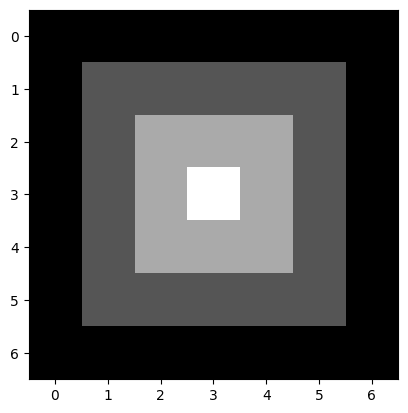

-----INPUT SHAPE-----
(56,160)
-----CONV_SETTING-----
strides:(4,4)
-----POOL_SETTING-----
type:max_pool
pool_size(2,2)
pool_strides(2,2)


In [4]:
working_directory = prerun_path_root + selected_pre_runs + "/"
print(f"----- Pre fixed conv2d runs -----:")
for file in os.listdir(working_directory):
    print(f" --> {file}") 
print(f"----- used_conv_kernel -----:")
kernel = np.load(working_directory +"conv2D_Kernel.npy")
print(f"--> shape:{kernel.shape}")
plt.imshow(kernel,cmap="gray")
plt.show()
#print(f"----- conv Setting ----- ")
with open(working_directory + "conv2D_Setting.txt","r") as file:
    for line in file:
        print(line.strip())

### Load Flattend_dataset

In [5]:
X,Y = np.load(working_directory + "Flattend_dataSet.npy"),np.load("/home/updyh/DataSet/master_row_hits_vertex.npy")
print(f"Dataloaded")
print(f"Input shape is{X.shape} ")
print(f"Output shape is{Y.shape} ")

Dataloaded
Input shape is(45484, 114) 
Output shape is(45484, 2) 


###  load Qmodel

In [7]:
def create_vertex_Qcnn(
             
    input_shape = (114),             
    output_size = 2,
     
    # Dense 
    neurons_per_dense_layer = [],  # int in list,
    
    # Dense Quantization
    dense_weight_quantizer = [],   # string in list
    dense_bias_quantizer  = [],     # string in list
    dense_activation_quantizer = [], #string in list
    
    dense_output_weight_quantizer = "",
    dense_output_bias_quantizer = ""
):

    # Input Layer
    
    x = x_in = keras.layers.Input(input_shape,name = "input")
    
    # Dense Block Generation
    for layer,neurons in enumerate(neurons_per_dense_layer):

        x = qkeras.QDense(     
                               neurons,
                               #kernel_initializer   = "random_normal",
                               #kernel_regularizer = l1(0.1),
                               name                 = f"dense_{layer}",
                               use_bias             = False  ,
            
                               #Quantization Scheme
                               kernel_quantizer     = dense_weight_quantizer[layer], 
                               bias_quantizer       = dense_bias_quantizer[layer]
                         )(x)
        
        #x = keras.layers.BatchNormalization(name = f"dense_bn_{layer}")(x)
        
        x = qkeras.QActivation(dense_activation_quantizer[layer],name = f"dense_act_{layer}")(x)
    
    # Output Dense layer
    
    #x_out = x = keras.layers.Dense(output_size,name = "dense_output",use_bias = False)(x)
    
    x_out = x = qkeras.QDense( 
                               output_size,
                               kernel_initializer   = "random_normal",
                               #kernel_regularizer = l1(0.0001),
                               name                 = "dense_output",
                               use_bias             = False,  
        
                               #Quantization Scheme
                               kernel_quantizer     = dense_output_weight_quantizer, 
                               bias_quantizer       = dense_output_bias_quantizer
                             )(x)
    
    model = keras.models.Model(
                               inputs               = x_in,
                               outputs              = x_out,
                               name                 = "Qmodel"
                               )
    return model 

In [15]:
Qmodel = create_vertex_Qcnn(
             
    input_shape = (114),             
    output_size = 2,

    # Dense 
    neurons_per_dense_layer = [20,15],  # int in list,
    
    # Dense Quantization
    
    dense_weight_quantizer =     [
        "quantized_bits(16,8,alpha=1)"    ,   # Dense 1 weight Quantizer
        "quantized_bits(16,8,alpha=1)"    ,   # Dense 2 weight Quantizer
     #   "quantized_bits(8,2)"
    ],   
    dense_bias_quantizer  =      [
        "quantized_bits(8,4,alpha=1)"    ,   # Dense 1 bias Quantizer
        "quantized_bits(8,4,alpha=1)"    ,   # Dense 2 bias Quantizer
     #   "quantized_bits(8,2)"
    ],     
    dense_activation_quantizer = [
        "quantized_relu(16,8)"  ,    # Dense 1 activation Quantizer
        "quantized_relu(16,8)"  ,    # Dense 2 activation Quantizer
     #   "quantized_relu(12,5)"
    ],
    
    dense_output_weight_quantizer = "quantized_bits(16,8,alpha=1)", # Dense output weight Quantizer
    dense_output_bias_quantizer =   "quantized_bits(16,8,alpha=1)"  # Dense output bias Quantizer
)

Qmodel.summary()
qkeras.print_qstats(Qmodel)
from qkeras.autoqkeras.utils import print_qmodel_summary
print_qmodel_summary(Qmodel) 

Model: "Qmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 114)]             0         
_________________________________________________________________
dense_0 (QDense)             (None, 20)                2280      
_________________________________________________________________
dense_act_0 (QActivation)    (None, 20)                0         
_________________________________________________________________
dense_1 (QDense)             (None, 15)                300       
_________________________________________________________________
dense_act_1 (QActivation)    (None, 15)                0         
_________________________________________________________________
dense_output (QDense)        (None, 2)                 30        
Total params: 2,610
Trainable params: 2,610
Non-trainable params: 0
__________________________________________________________

### Qmodel Training

In [8]:
#Qmodel = tf.keras.models.load_model("runs/Q_Embedding_Model_v2_ap_24_8.h5" ,custom_objects=co)

In [22]:
Qmodel.compile(
optimizer=keras.optimizers.Adam(0.000015),
loss = "mse",
metrics=[
        #keras.metrics.MeanSquaredError(),
        #keras.metrics.RootMeanSquaredError(),
        #keras.metrics.MeanAbsoluteError(name="Mean Error in cm", dtype=None),
        keras.metrics.RootMeanSquaredError(name = "Distance Deviation in CM ",)
])

In [24]:
Qmodel.fit(
#x = x.reshape((x.shape[0],56,160,1)),
#x = fpga_preprocessing(x.reshape((x.shape[0],56,160,1)),fpga_filter_in,[1,4,4,1]),
x = X,
y = Y,        
batch_size= 50,
validation_split=0.1,
validation_freq=10,
epochs = 1000,
verbose = 1,
#use_multiprocessing=True 
)

Epoch 1/1000
819/819 [==============================] - 1s 752us/step - loss: 127.8598 - Distance Deviation in CM : 11.3075
Epoch 2/1000
819/819 [==============================] - 1s 764us/step - loss: 127.8572 - Distance Deviation in CM : 11.3074
Epoch 3/1000
819/819 [==============================] - 1s 749us/step - loss: 127.8046 - Distance Deviation in CM : 11.3051
Epoch 4/1000
819/819 [==============================] - 1s 750us/step - loss: 127.8172 - Distance Deviation in CM : 11.3056
Epoch 5/1000
819/819 [==============================] - 1s 747us/step - loss: 127.8002 - Distance Deviation in CM : 11.3049
Epoch 6/1000
819/819 [==============================] - 1s 744us/step - loss: 127.8412 - Distance Deviation in CM : 11.3067
Epoch 7/1000
819/819 [==============================] - 1s 740us/step - loss: 127.7591 - Distance Deviation in CM : 11.3031
Epoch 8/1000
819/819 [==============================] - 1s 740us/step - loss: 127.7814 - Distance Deviation in CM : 11.3040
Epoch 9/

### Save the model


In [25]:
for file in os.listdir(working_directory):
    print(file)

hls4ml_compile_002_v10
hls4ml_compile_004_v3
conv2D_Setting.txt
009.h5
hls4ml_compile_004_v4
008.h5
hls4ml_compile_002_v7
hls4ml_compile_002_v9
hls4ml_compile_002_v3
hls4ml_compile_001_fixed_8_4_12_5
Flattend_dataSet.npy
hls4ml_compile_008_v1
conv2D_Kernel.npy
hls4ml_compile_009_v1
hls4ml_compile_002_v4
hls4ml_compile_004_v5
010.h5
007.h5
hls4ml_compile_002_v6
011.h5
Parallel_conv2D_Hardware_Design
013.h5
hls4ml_compile_003_v1
004.h5
005.h5
hls4ml_compile_004_v2
012.h5
hls4ml_compile_001_fixed_12_5_12_5
001.h5
hls4ml_compile_002_v5
hls4ml_compile_011_v1
hls4ml_compile_010_v1
002.h5
hls4ml_compile_005_v1
hls4ml_compile_012_v1
hls4ml_compile_002_v2
hls4ml_compile_002_v8
hls4ml_compile_013_v1
hls4ml_compile_004_v1
003.h5


In [26]:
file_name = "V014_11_0_117.h5"

Qmodel.save(working_directory + file_name)

for file in os.listdir(working_directory):
    print(file)

hls4ml_compile_002_v10
hls4ml_compile_004_v3
conv2D_Setting.txt
009.h5
hls4ml_compile_004_v4
008.h5
hls4ml_compile_002_v7
hls4ml_compile_002_v9
hls4ml_compile_002_v3
hls4ml_compile_001_fixed_8_4_12_5
Flattend_dataSet.npy
hls4ml_compile_008_v1
conv2D_Kernel.npy
hls4ml_compile_009_v1
hls4ml_compile_002_v4
hls4ml_compile_004_v5
010.h5
007.h5
hls4ml_compile_002_v6
011.h5
Parallel_conv2D_Hardware_Design
013.h5
hls4ml_compile_003_v1
004.h5
005.h5
hls4ml_compile_004_v2
012.h5
hls4ml_compile_001_fixed_12_5_12_5
001.h5
hls4ml_compile_002_v5
hls4ml_compile_011_v1
hls4ml_compile_010_v1
002.h5
hls4ml_compile_005_v1
V014_11_0_117.h5
hls4ml_compile_012_v1
hls4ml_compile_002_v2
hls4ml_compile_002_v8
hls4ml_compile_013_v1
hls4ml_compile_004_v1
003.h5


## Hardware Synthese steps  (HLS4ML)
* Load The Qmodel
* sythese setting 
* build project

### Load Qmodel

In [27]:
selected_model = "V014_11_0_117.h5"

from qkeras.utils import _add_supported_quantized_objects
from qkeras.autoqkeras.utils import print_qmodel_summary
co = {}
_add_supported_quantized_objects(co)
Qmodel = tf.keras.models.load_model(working_directory + selected_model ,custom_objects=co)
#Qmodel = tf.keras.models.load_model("runs/Q_Embedding_Model_v2_ap_24_8.h5" ,custom_objects=co)
Qmodel.summary()
qkeras.print_qstats(Qmodel)
print_qmodel_summary(Qmodel) 

Model: "Qmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 114)]             0         
_________________________________________________________________
dense_0 (QDense)             (None, 20)                2280      
_________________________________________________________________
dense_act_0 (QActivation)    (None, 20)                0         
_________________________________________________________________
dense_1 (QDense)             (None, 15)                300       
_________________________________________________________________
dense_act_1 (QActivation)    (None, 15)                0         
_________________________________________________________________
dense_output (QDense)        (None, 2)                 30        
Total params: 2,610
Trainable params: 2,610
Non-trainable params: 0
__________________________________________________________

### HLS4ML compile setting

In [29]:
compile_outdir = working_directory + "hls4ml_compile_V14/"

Interpreting Model
Topology:
Layer name: input, layer type: Input
Layer name: dense_0, layer type: QDense
Layer name: dense_act_0, layer type: QActivation
Layer name: dense_1, layer type: QDense
Layer name: dense_act_1, layer type: QActivation
Layer name: dense_output, layer type: QDense
Model
  Precision:         ap_fixed<16,10>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  input
    Precision:       ap_fixed<16,10>
  dense_0
    Precision
      weight:        ap_fixed<16,9>
      bias:          ap_fixed<8,5>
    ReuseFactor:     1
  dense_act_0
    Precision
      result:        ap_ufixed<16,8>
    ReuseFactor:     1
  dense_1
    Precision
      weight:        ap_fixed<16,9>
      bias:          ap_fixed<8,5>
    ReuseFactor:     1
  dense_act_1
    Precision
      result:        ap_ufixed<16,8>
    ReuseFactor:     1
  dense_output
    Precision
      weight:        ap_fixed<16,9>
      bias:          ap_fixed<16,9>
    ReuseFactor:     1
Interpreting Model
Topolo

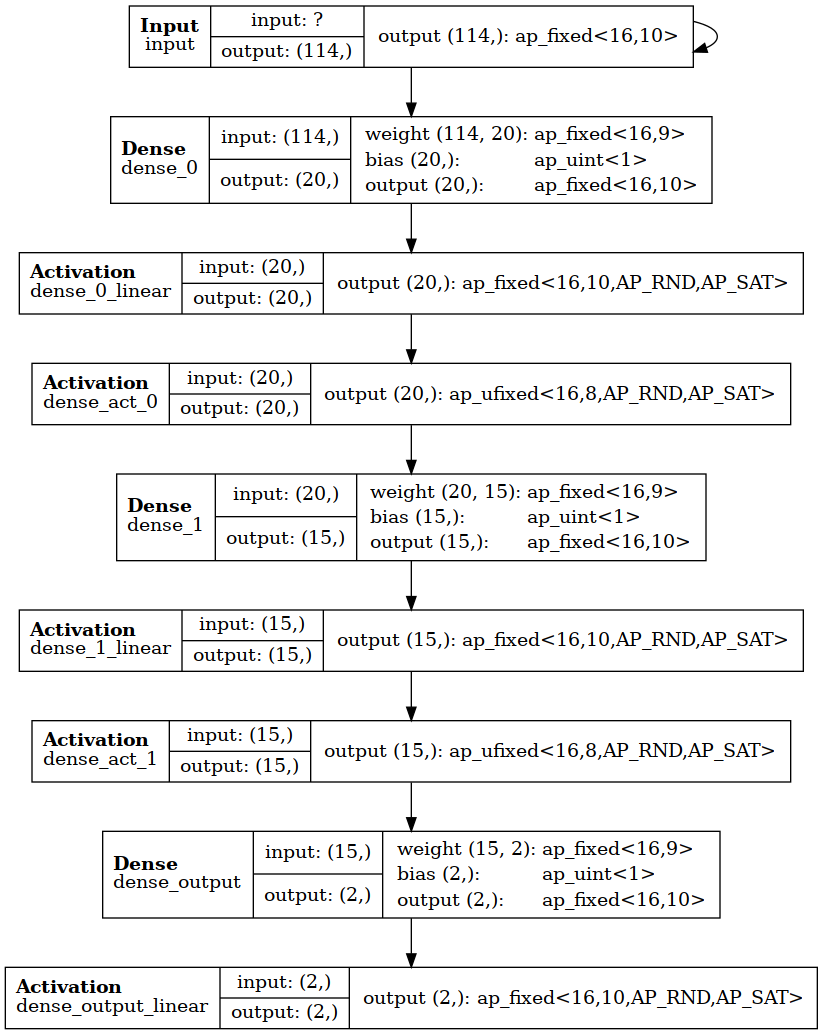

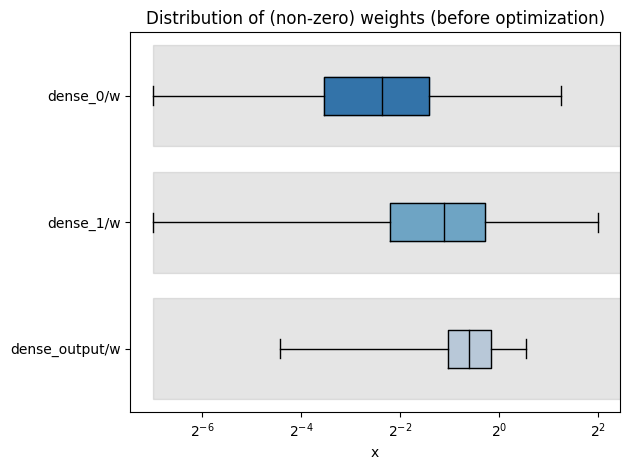

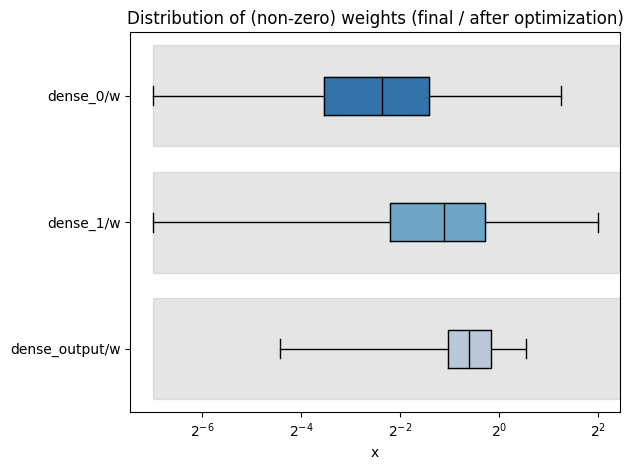

In [37]:
import plotting
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hls_config_q = hls4ml.utils.config_from_keras_model(Qmodel, granularity='name')
hls_config_q['Model']['ReuseFactor'] = 1
hls_config_q['Model']['Precision'] = 'ap_fixed<16,10>'
hls_config_q["LayerName"]["input"]['Precision'] = 'ap_fixed<16,10>'
#hls_config_q['LayerName']['dense_output']['Precision'] = 'ap_fixed<32,16>'
#hls_config_q['LayerName']['dense_0']['Precision'] = 'ap_fixed<25,12>'
#hls_config_q['LayerName']['dense_output']['Strategy'] = 'latency'

plotting.print_dict(hls_config_q)

cfg_q = hls4ml.converters.create_config(backend='Vivado')
cfg_q['IOType']     = 'io_parallel' 
#cfg_q['IOType']     = 'io_stream'
cfg_q['HLSConfig']  = hls_config_q
cfg_q['KerasModel'] = Qmodel
cfg_q['OutputDir']  = compile_outdir 
cfg_q['XilinxPart'] = 'xcvu160-flgb2104-2-e'
  
hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls4ml.model.profiling.numerical(model=Qmodel, hls_model=hls_model_q)
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None) 

### hls4ml_compile

In [38]:
hls_model_q.compile()

Writing HLS project
Done


### hls4ml prediction

In [45]:
predictions_weightquantized = Qmodel(X)
predictions_allquantized = hls_model_q.predict(X)

absolute_deviation_weightquantized = np.absolute( predictions_weightquantized  - Y)
absolute_deviation_allquantized    = np.absolute( predictions_allquantized  - Y)

error_accmulator_weightquantized,error_accmulator_allquantized = [] ,[]  
for i,[x_deviation,y_deviation] in enumerate(absolute_deviation_weightquantized):
    error_accmulator_weightquantized.append( (x_deviation**2 + y_deviation**2) ** 0.5)

for i,[x_deviation,y_deviation] in enumerate(absolute_deviation_allquantized):
    error_accmulator_allquantized.append( (x_deviation**2 + y_deviation**2) ** 0.5)

#print(f"Average Error Over all is : {error_accmulator / 45484 } cm")
print(f"Average Distance deviation over all {X.shape[0]} is: ")
print(f"Qkeras model lr:1e-5 ep:1200 ba:50 : {sum(error_accmulator_weightquantized) / len(error_accmulator_weightquantized)} cm")
print(f"HSL4ml modul : {sum(error_accmulator_allquantized) / len(error_accmulator_allquantized)} cm")


Average Distance deviation over all 45484 is: 
Qkeras model lr:1e-5 ep:1200 ba:50 : 10.832547781633039 cm
HSL4ml modul : 10.858948879412102 cm


In [43]:
idx = 603
print(predictions_weightquantized[idx])
print(predictions_allquantized[idx])
print(Y[idx])

tf.Tensor([20.306915  -7.7185974], shape=(2,), dtype=float32)
[20.09375  -7.765625]
[ 29.24 -15.38]


### hls4ml_synthese

In [44]:
hls_model_q.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2700185 on Thu Oct 24 18:45:48 MDT 2019
  **** IP Build 2699827 on Thu Oct 24 21:16:38 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/xilinx/ISE_EDK/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/tools/xilinx/ISE_EDK/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'updyh' on host 'work5.itiv.kit.edu' (Linux_x86_64 version 4.18.0-425.19.2.el8_7.x86_64) on Mon Apr 24 00:02:06 CEST 2023
INFO: [HLS 200-10] On os "Rocky Linux release 8.7 (Green Obsidian)"
INFO: [HLS 200-10] In directory '/home/updyh/BelleII_CNN_conv2D_runs/Friday_April_04_07_23_18_31_50/hls4ml_compile_V14'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/updyh/BelleII_CNN_conv2D_runs/Friday_April_04_07_23_18_31_50/hls4ml_compile_V14/m

{'EstimatedClockPeriod': '4.368',
 'BestLatency': '10',
 'WorstLatency': '10',
 'IntervalMin': '1',
 'IntervalMax': '1',
 'DSP48E': '1137',
 'FF': '39349',
 'LUT': '85077',
 'BRAM_18K': '0',
 'URAM': '0',
 'AvailableBRAM_18K': '6552',
 'AvailableDSP48E': '1560',
 'AvailableFF': '1852800',
 'AvailableLUT': '926400',
 'AvailableURAM': '0'}

In [19]:
hls4ml.report.read_vivado_report(compile_outdir)

Found 1 solution(s) in /home/updyh/BelleII_CNN_conv2D_runs/Friday_April_04_07_23_18_31_50/hls4ml_compile_013_v1//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Mon Apr 17 01:00:08 2023

* Version:        2019.2 (Build 2698951 on Thu Oct 24 19:15:34 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexu
* Target device:  xcvu160-flgb2104-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.270 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+----------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline |
    |   min   |   max   |    min   